# Final EDA and Linear Regression Model

In [25]:
# Load in necessary packages
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from statsmodels.graphics.regressionplots import plot_partregress_grid
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [129]:
# Read in csv file
coffee = pd.read_csv('linear.csv')

In [130]:
country_counts = coffee['country'].value_counts()

threshold = 8
valid_countries = country_counts[country_counts >= threshold].index

coffee = coffee[coffee['country'].isin(valid_countries)]

In [131]:
coffee['country'].value_counts()

country
Taiwan       106
Vietnam       89
Thailand      61
Indonesia     31
Colombia      24
Ethiopia      16
Kenya         13
Brazil        13
Guatemala     11
India          8
Name: count, dtype: int64

## Target Variable Plots (on same page)

<Axes: title={'center': 'Correlation Matrix of Scale Scored Variables'}>

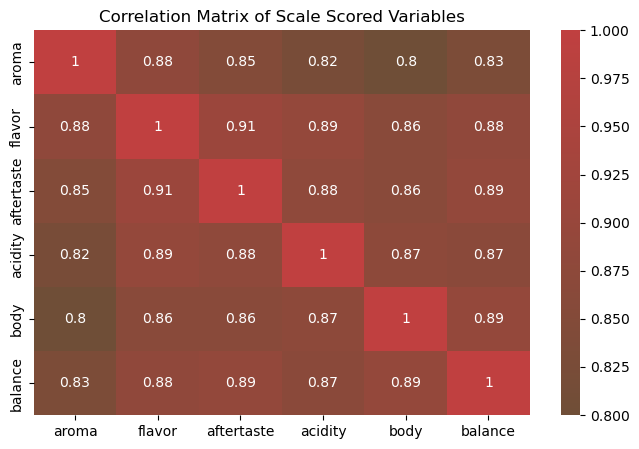

In [27]:
# Plot that shows extreme multicolinearity and restricted range of variables in total_quality

from matplotlib.colors import LinearSegmentedColormap
corr = coffee.loc[:, 'aroma':'balance'].corr()
plt.figure(figsize=(8,5))
plt.title("Correlation Matrix of Scale Scored Variables")

custom_cmap = LinearSegmentedColormap.from_list(
    'coffee_red', ['#6F4E37', '#C04040'], N=256)
sns.heatmap(corr, annot=True, cmap=custom_cmap)

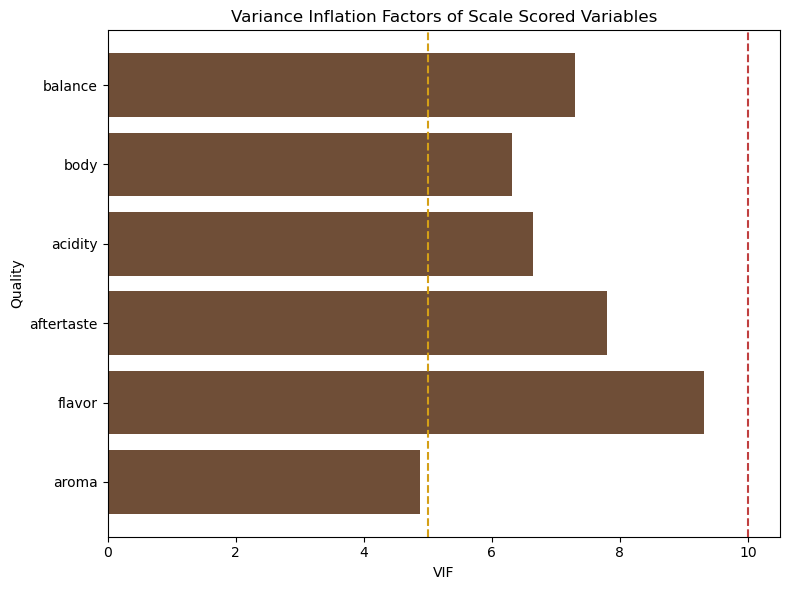

In [89]:
# VIF graph for variables in total_quality

scaler = StandardScaler()
standard_cols = ['aroma', 'flavor', 'aftertaste', 'acidity', 'body', 'balance']
coffee[standard_cols] = scaler.fit_transform(coffee[standard_cols])
X = coffee[['aroma', 'flavor', 'aftertaste', 'acidity', 'body', 'balance']]

vif_df = pd.DataFrame()
vif_df["variable"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

plt.figure(figsize=(8,6))
plt.barh(vif_df['variable'], vif_df['VIF'], color=['#6F4E37'])
plt.axvline(5, color="#D4A017", linestyle='--')
plt.axvline(10, color='#C04040', linestyle='--')
plt.xlabel("VIF")
plt.ylabel("Quality")
plt.title("Variance Inflation Factors of Scale Scored Variables")
plt.tight_layout()
plt.show()

### Buttons for VIF Plot:

- Select which variables to include in graph
- Select whether to sort by ascending/descending order or order in dataframe (normal)
- Click to include either dotted line (VIF = 5 meaning might be colinearity; VIF = 10 meaning colinearity is most likely present)

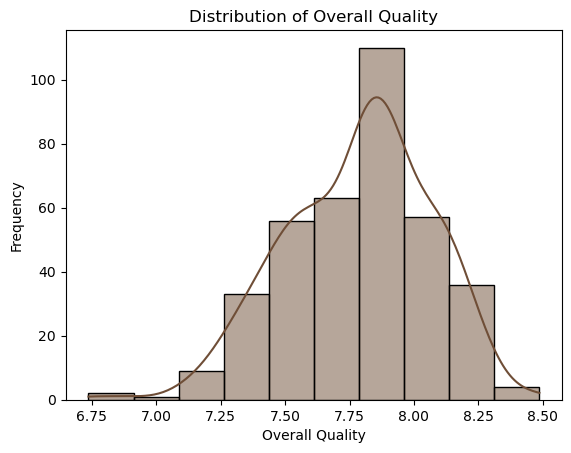

In [136]:
sns.histplot(coffee['total_quality'], bins=10, kde=True, color='#6F4E37')
plt.title('Distribution of Overall Quality')
plt.xlabel('Overall Quality')
plt.ylabel('Frequency')
plt.show()

## New Page: Predictor Variables on Overall Quality

/var/folders/k2/xkhh4x_x2999dprlhrz1h_r00000gn/T/ipykernel_80517/206564701.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




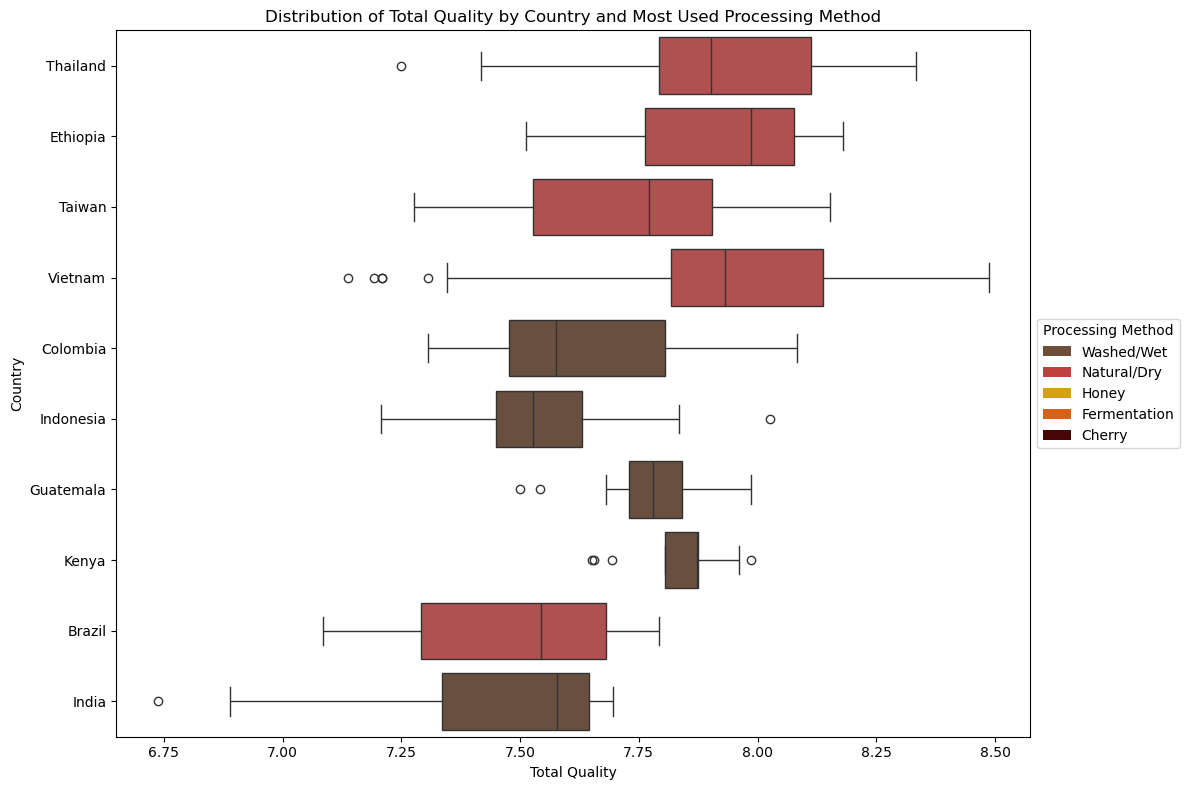

In [132]:
# Observe total_quality grouped by country and most used processing method

coffee['country'] = coffee['country'].replace({
    "Tanzania, United Republic Of": "Tanzania"
})


mode_processing = coffee.groupby('country')['processing_method'] \
                       .agg(lambda x: x.mode()[0])

processing_palette = {
    'Washed/Wet': '#6F4E37',     
    'Natural/Dry': '#C04040',    
    'Honey': '#D4A017',
    'Fermentation': "#D46217",
    'Cherry': "#460606"      
}

plt.figure(figsize=(12,8))

country_colors = mode_processing.map(processing_palette)

processing_dict = country_colors.to_dict()

sns.boxplot(
    y='country',          
    x='total_quality',    
    data=coffee,
    palette=processing_dict       
)

plt.title("Distribution of Total Quality by Country and Most Used Processing Method")
plt.ylabel("Country")
plt.xlabel("Total Quality")

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=method) 
                   for method, color in processing_palette.items()]
plt.legend(handles=legend_elements, title="Processing Method", 
           loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

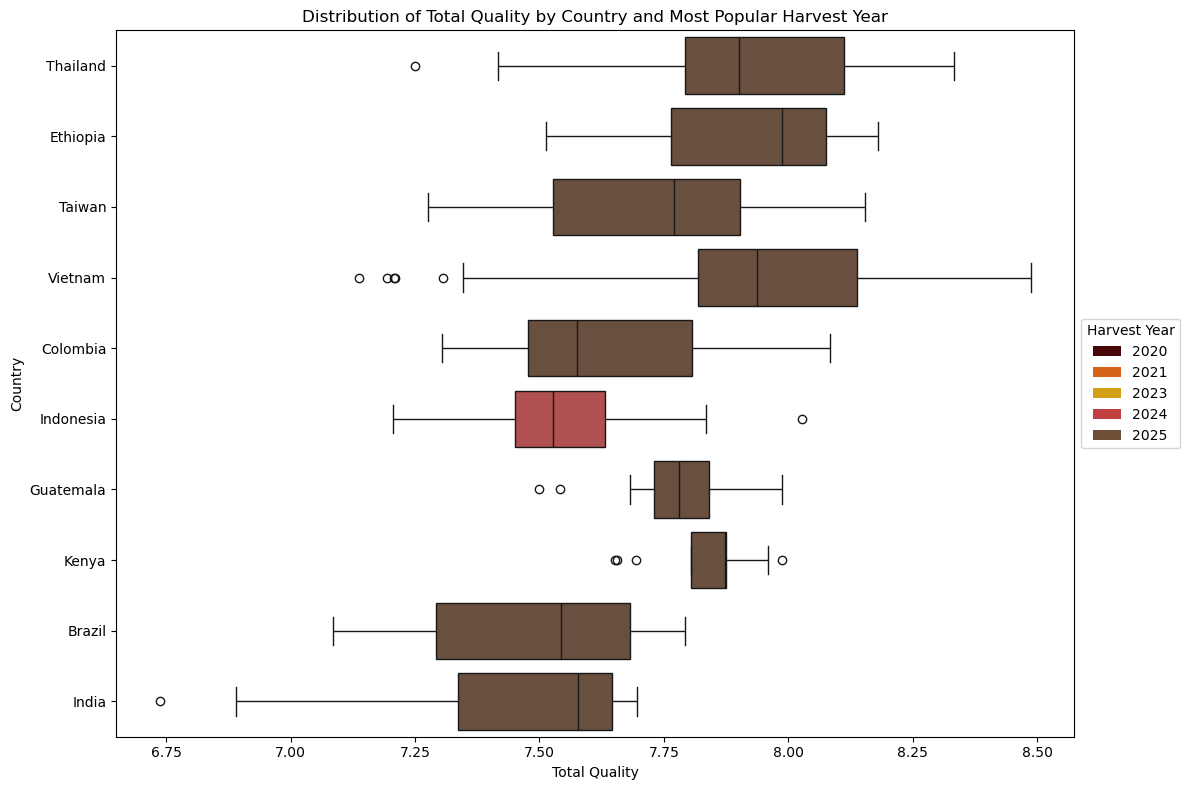

In [133]:
from matplotlib.patches import Patch

coffee['country'] = coffee['country'].replace({
    "Tanzania, United Republic Of": "Tanzania"
})

coffee = coffee.dropna(subset=['harvest_year'])
coffee = coffee[coffee['harvest_year'] != 2026]

mode_harvest = coffee.groupby('country')['harvest_year'].agg(lambda x: x.mode()[0])

coffee['mode_harvest_year'] = coffee['country'].map(mode_harvest)
coffee['mode_harvest_year'] = coffee['mode_harvest_year'].astype(str) 

harvest_palette = {
    '2020': "#460606",
    '2021': "#D46217",
    '2023': "#D4A017",
    '2024': "#C04040",
    '2025': "#6F4E37"
}

plt.figure(figsize=(12,8))

sns.boxplot(
    y='country',                 
    x='total_quality',
    hue='mode_harvest_year',    
    data=coffee,
    palette=harvest_palette,
    dodge=False                  
)

plt.title("Distribution of Total Quality by Country and Most Popular Harvest Year")
plt.xlabel("Total Quality")
plt.ylabel("Country")

legend_elements = [
    Patch(facecolor=color, label=year) 
    for year, color in harvest_palette.items()
]

plt.legend(
    handles=legend_elements,
    title="Harvest Year",
    loc='center left',
    bbox_to_anchor=(1, 0.5)
)

plt.tight_layout()
plt.show()


## New Page: Linear Regression Models

                            OLS Regression Results                            
Dep. Variable:          total_quality   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     19.40
Date:                Sun, 30 Nov 2025   Prob (F-statistic):           1.50e-30
Time:                        22:53:43   Log-Likelihood:                 31.537
No. Observations:                 371   AIC:                            -39.07
Df Residuals:                     359   BIC:                             7.920
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                4.9663 

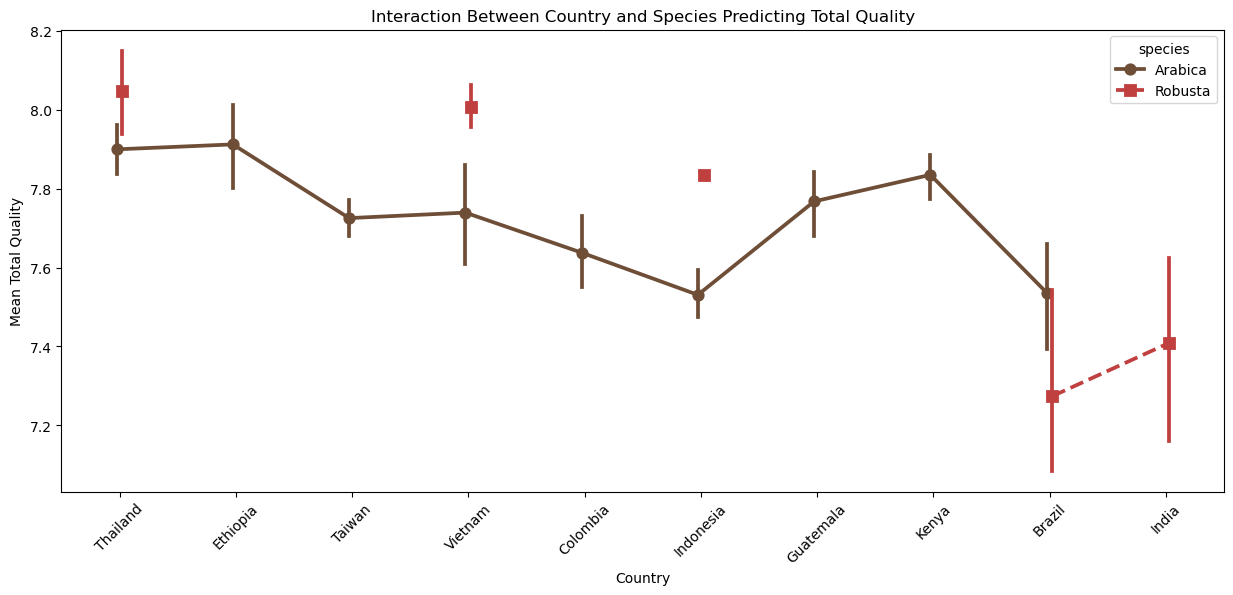

0.2307026751570962


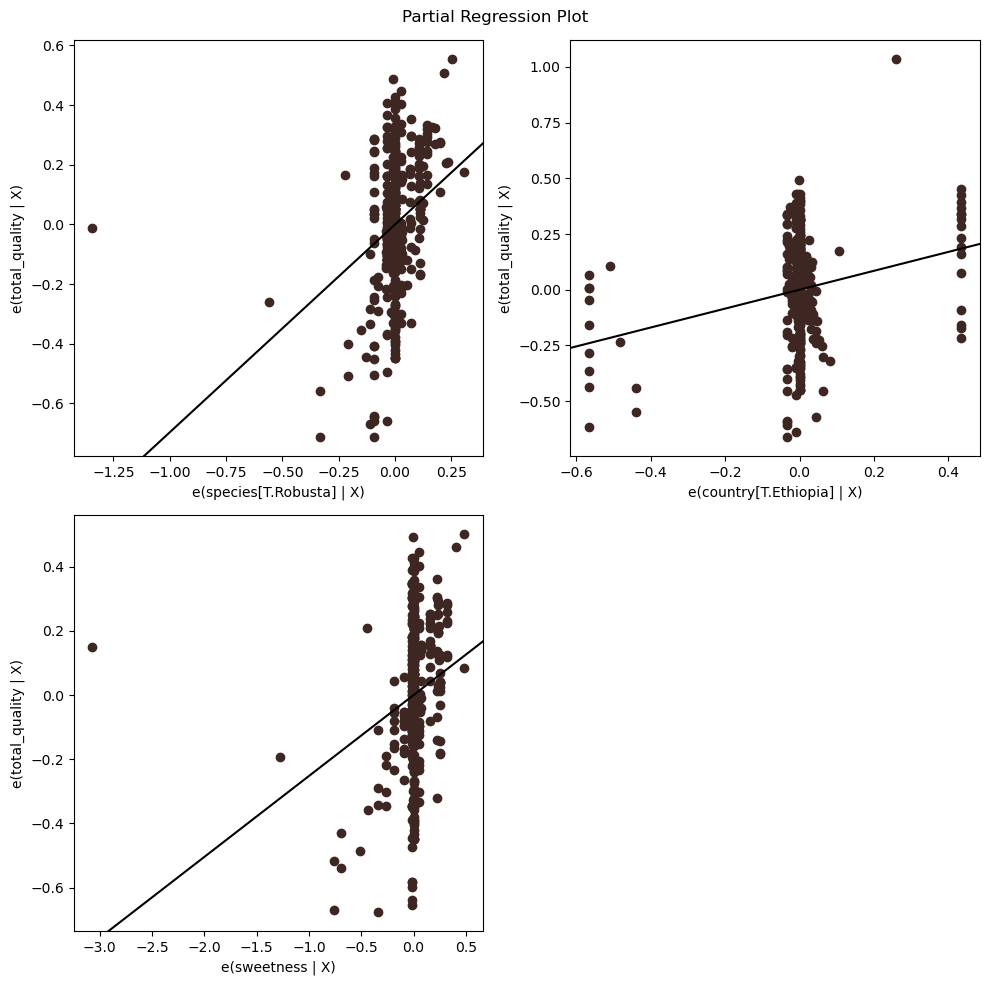

In [135]:
# Model with country, species, and sweetness as predictors
model = smf.ols(formula='total_quality~country+species+sweetness',data=coffee).fit()
print(model.summary())

plt.figure(figsize=(15,6))

palette = ["#6F4E37", "#C04040"]

# Use different plot 
sns.pointplot(
    x='country',
    y='total_quality',
    hue='species',
    data=coffee,
    palette=palette,
    dodge=True,
    markers=['o','s'],
    linestyles=['-', '--']
)

plt.xticks(rotation=45)
plt.title("Interaction Between Country and Species Predicting Total Quality")
plt.ylabel("Mean Total Quality")
plt.xlabel("Country")
plt.show()

# One Hot Encoder
cats=["country", "species"]
nums=['sweetness']

preprocess=ColumnTransformer(transformers=[("encoder", OneHotEncoder(drop="first", handle_unknown='ignore'),cats),
                                           ("numeric","passthrough",nums)])

# Train-test split
X=coffee[['country','species', 'sweetness']]
y=coffee['total_quality']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=123)
ols=Pipeline(steps=[("preprocess", preprocess), ("model", LinearRegression())])
ols.fit(X_train, y_train)

# Train-test split
X=coffee[['country','species','sweetness']]
y=coffee['total_quality']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=123)
ols=Pipeline(steps=[("preprocess", preprocess), ("model", LinearRegression())])
ols.fit(X_train, y_train)

model1=ols.named_steps["model"]
predictors=ols.named_steps["preprocess"].get_feature_names_out()

charges_pred=ols.predict(X_test)
mse=mean_squared_error(y_test, charges_pred)
rmse=mse**0.5
print(rmse)

dat=pd.DataFrame({"Actual": y_test, "Predicted": charges_pred})

fig = px.scatter(dat,x="Actual",y="Predicted", trendline="ols")
fig.show()

# Residual vs. fitted plot
coffee['residual']=model.resid
coffee['fitted']=model.fittedvalues

fig=px.scatter(coffee, x="fitted", y="residual")
fig.add_hline(y=0, line_dash="dash", line_color="red")
fig.show()

# Partial regression plots
include=["species[T.Robusta]","country[T.Ethiopia]", 'sweetness']
graph=plt.figure(figsize=(10,10))
plot_partregress_grid(model, fig=graph,exog_idx=include)
plt.show()

                            OLS Regression Results                            
Dep. Variable:          total_quality   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     9.114
Date:                Sun, 30 Nov 2025   Prob (F-statistic):           2.74e-25
Time:                        22:30:42   Log-Likelihood:                 29.923
No. Observations:                 398   AIC:                            -9.845
Df Residuals:                     373   BIC:                             89.82
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

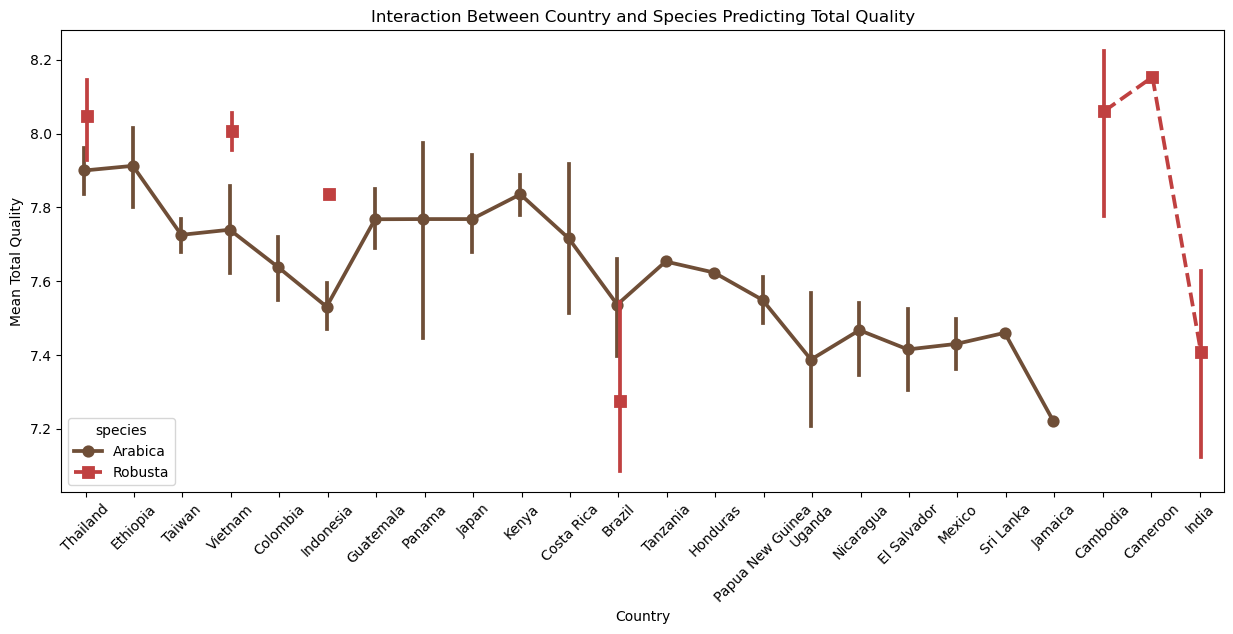

0.25084569974572846


/opt/miniconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



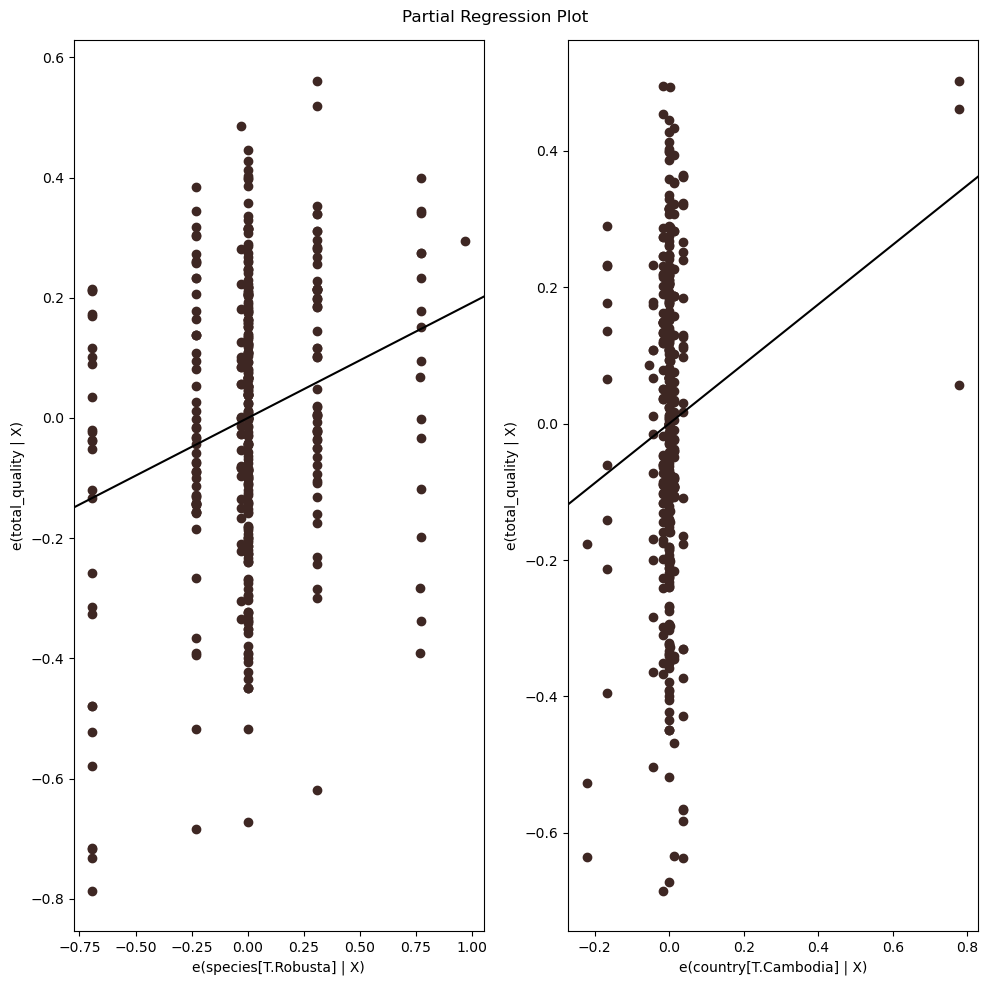

In [118]:
# Model with country and species as predictors
model = smf.ols(formula='total_quality~country+species',data=coffee).fit()
print(model.summary())

plt.figure(figsize=(15,6))

palette = ["#6F4E37", "#C04040"]

sns.pointplot(
    x='country',
    y='total_quality',
    hue='species',
    data=coffee,
    palette=palette,
    dodge=True,
    markers=['o','s'],
    linestyles=['-', '--']
)

plt.xticks(rotation=45)
plt.title("Interaction Between Country and Species Predicting Total Quality")
plt.ylabel("Mean Total Quality")
plt.xlabel("Country")
plt.show()

# One Hot Encoder
cats=["country", "species"]

preprocess=ColumnTransformer(transformers=[("encoder", OneHotEncoder(drop="first", handle_unknown='ignore'),cats)])

# Train-test split
X=coffee[['country','species']]
y=coffee['total_quality']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=123)
ols=Pipeline(steps=[("preprocess", preprocess), ("model", LinearRegression())])
ols.fit(X_train, y_train)

# Train-test split
X=coffee[['country','species']]
y=coffee['total_quality']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=123)
ols=Pipeline(steps=[("preprocess", preprocess), ("model", LinearRegression())])
ols.fit(X_train, y_train)

model1=ols.named_steps["model"]
predictors=ols.named_steps["preprocess"].get_feature_names_out()

charges_pred=ols.predict(X_test)
mse=mean_squared_error(y_test, charges_pred)
rmse=mse**0.5
print(rmse)

dat=pd.DataFrame({"Actual": y_test, "Predicted": charges_pred})

fig = px.scatter(dat,x="Actual",y="Predicted", trendline="ols")
fig.show()

# Residual vs. fitted plot
coffee['residual']=model.resid
coffee['fitted']=model.fittedvalues

fig=px.scatter(coffee, x="fitted", y="residual")
fig.add_hline(y=0, line_dash="dash", line_color="red")
fig.show()

# Partial regression plots
include=["species[T.Robusta]","country[T.Cambodia]"]
graph=plt.figure(figsize=(10,10))
plot_partregress_grid(model, fig=graph,exog_idx=include)
plt.show()

                            OLS Regression Results                            
Dep. Variable:          total_quality   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     47.12
Date:                Sun, 30 Nov 2025   Prob (F-statistic):           4.45e-19
Time:                        22:40:59   Log-Likelihood:                -19.339
No. Observations:                 398   AIC:                             44.68
Df Residuals:                     395   BIC:                             56.64
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              7.5607      0

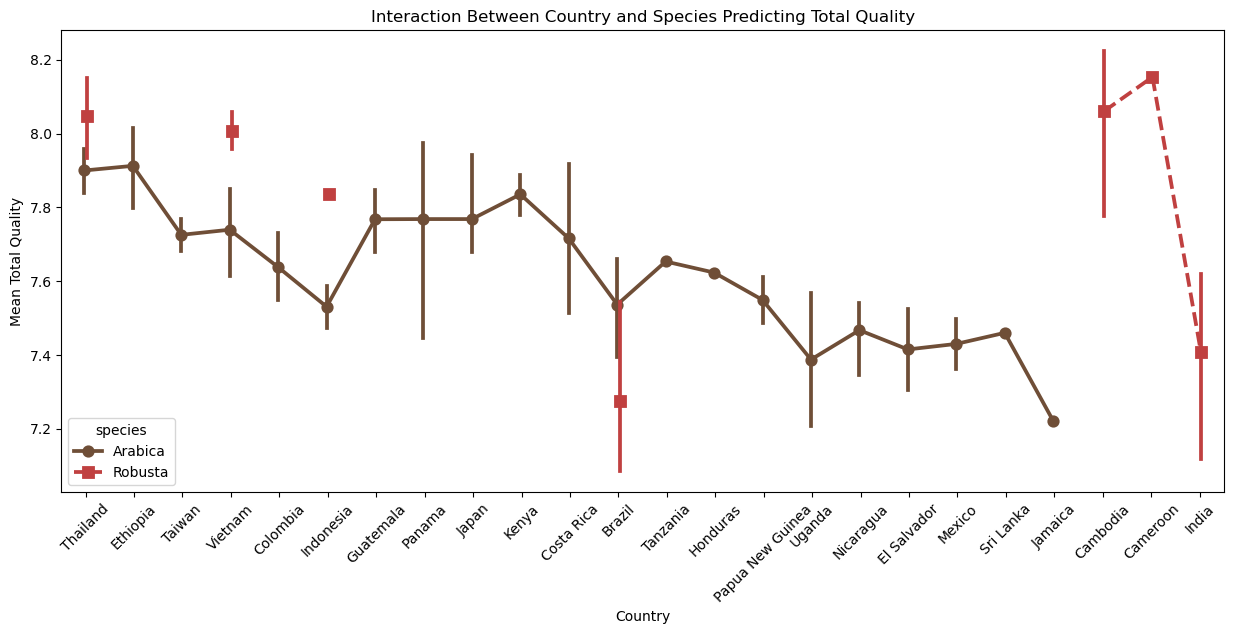

0.3503705184747149


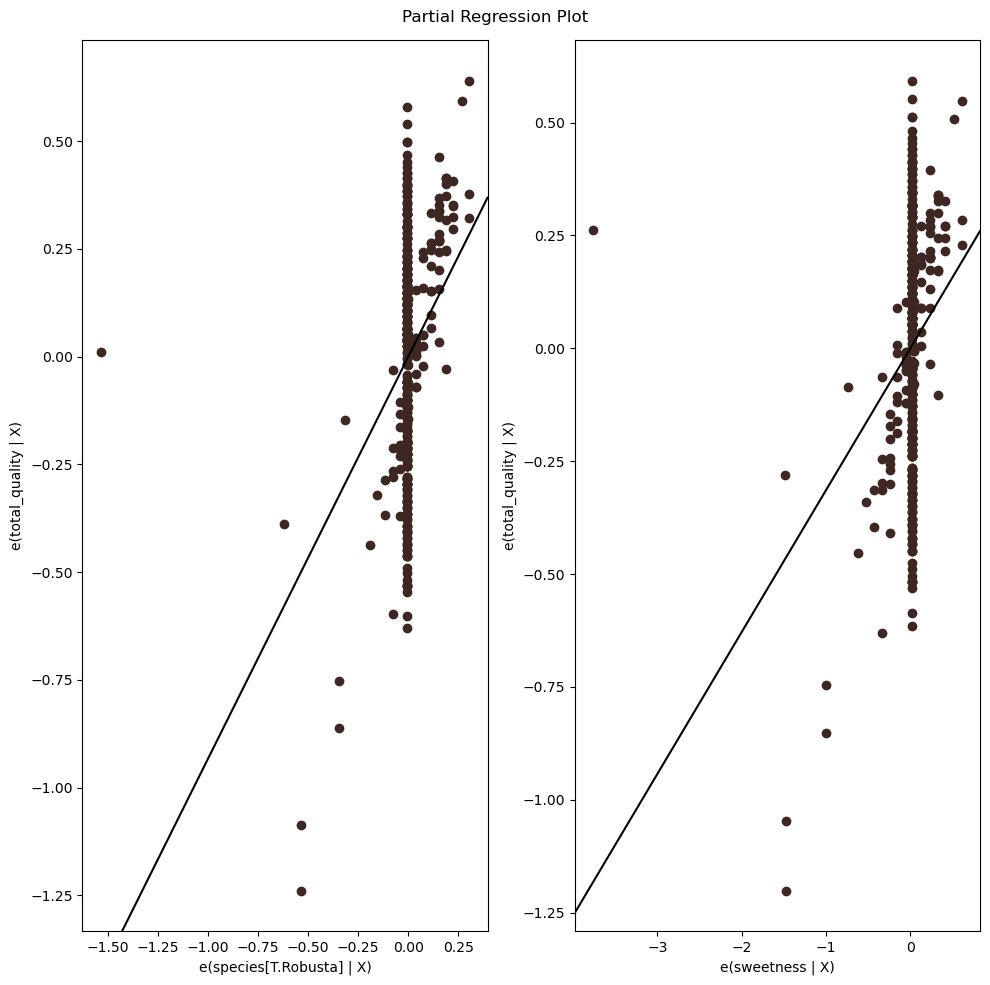

In [121]:
# Model with sweetness and species as predictors
model = smf.ols(formula='total_quality~sweetness+species',data=coffee).fit()
print(model.summary())

plt.figure(figsize=(15,6))

palette = ["#6F4E37", "#C04040"]

sns.pointplot(
    x='country',
    y='total_quality',
    hue='species',
    data=coffee,
    palette=palette,
    dodge=True,
    markers=['o','s'],
    linestyles=['-', '--']
)

plt.xticks(rotation=45)
plt.title("Interaction Between Country and Species Predicting Total Quality")
plt.ylabel("Mean Total Quality")
plt.xlabel("Country")
plt.show()

# One Hot Encoder
cats=["species"]
nums=["sweetness"]

preprocess=ColumnTransformer(transformers=[("encoder", OneHotEncoder(drop="first", handle_unknown='ignore'),cats),
                                           ("numeric","passthrough",nums)])

# Train-test split
X=coffee[['sweetness','species']]
y=coffee['total_quality']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=123)
ols=Pipeline(steps=[("preprocess", preprocess), ("model", LinearRegression())])
ols.fit(X_train, y_train)

# Train-test split
X=coffee[['sweetness','species']]
y=coffee['total_quality']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=123)
ols=Pipeline(steps=[("preprocess", preprocess), ("model", LinearRegression())])
ols.fit(X_train, y_train)

model1=ols.named_steps["model"]
predictors=ols.named_steps["preprocess"].get_feature_names_out()

charges_pred=ols.predict(X_test)
mse=mean_squared_error(y_test, charges_pred)
rmse=mse**0.5
print(rmse)

dat=pd.DataFrame({"Actual": y_test, "Predicted": charges_pred})

fig = px.scatter(dat,x="Actual",y="Predicted", trendline="ols")
fig.show()

# Residual vs. fitted plot
coffee['residual']=model.resid
coffee['fitted']=model.fittedvalues

fig=px.scatter(coffee, x="fitted", y="residual")
fig.add_hline(y=0, line_dash="dash", line_color="red")
fig.show()

# Partial regression plots
include=["species[T.Robusta]","sweetness"]
graph=plt.figure(figsize=(10,10))
plot_partregress_grid(model, fig=graph,exog_idx=include)
plt.show()

                            OLS Regression Results                            
Dep. Variable:          total_quality   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     8.156
Date:                Sun, 30 Nov 2025   Prob (F-statistic):           2.05e-22
Time:                        22:42:47   Log-Likelihood:                 22.036
No. Observations:                 398   AIC:                             5.927
Df Residuals:                     373   BIC:                             105.6
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

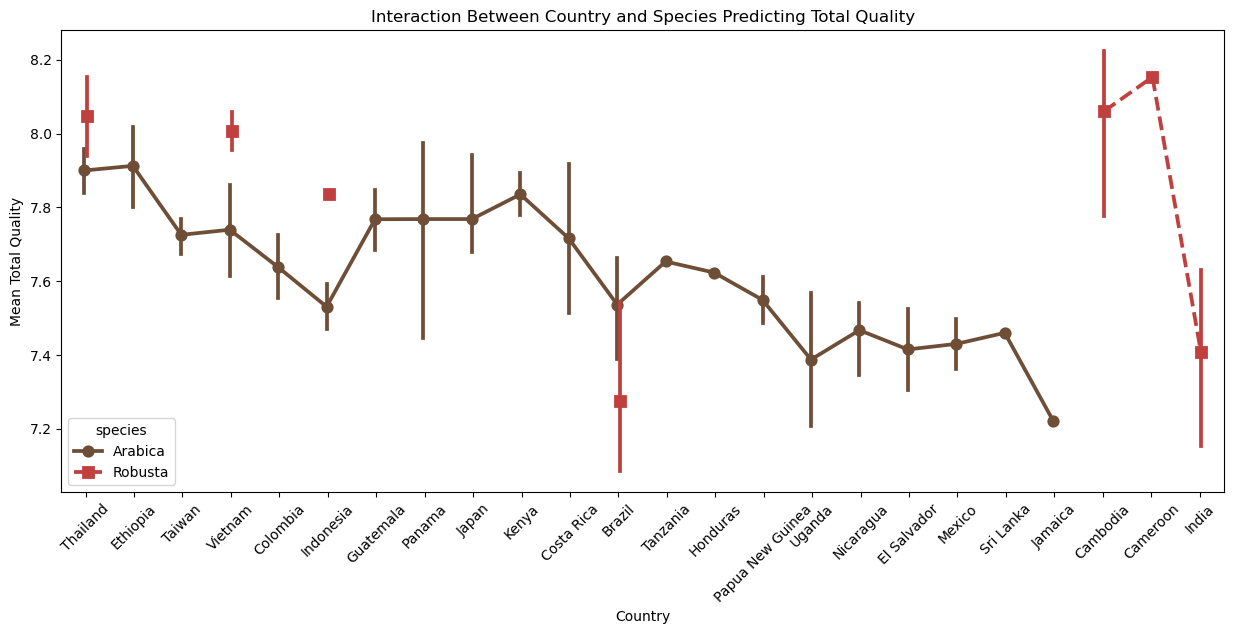

0.2528227539219428


/opt/miniconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



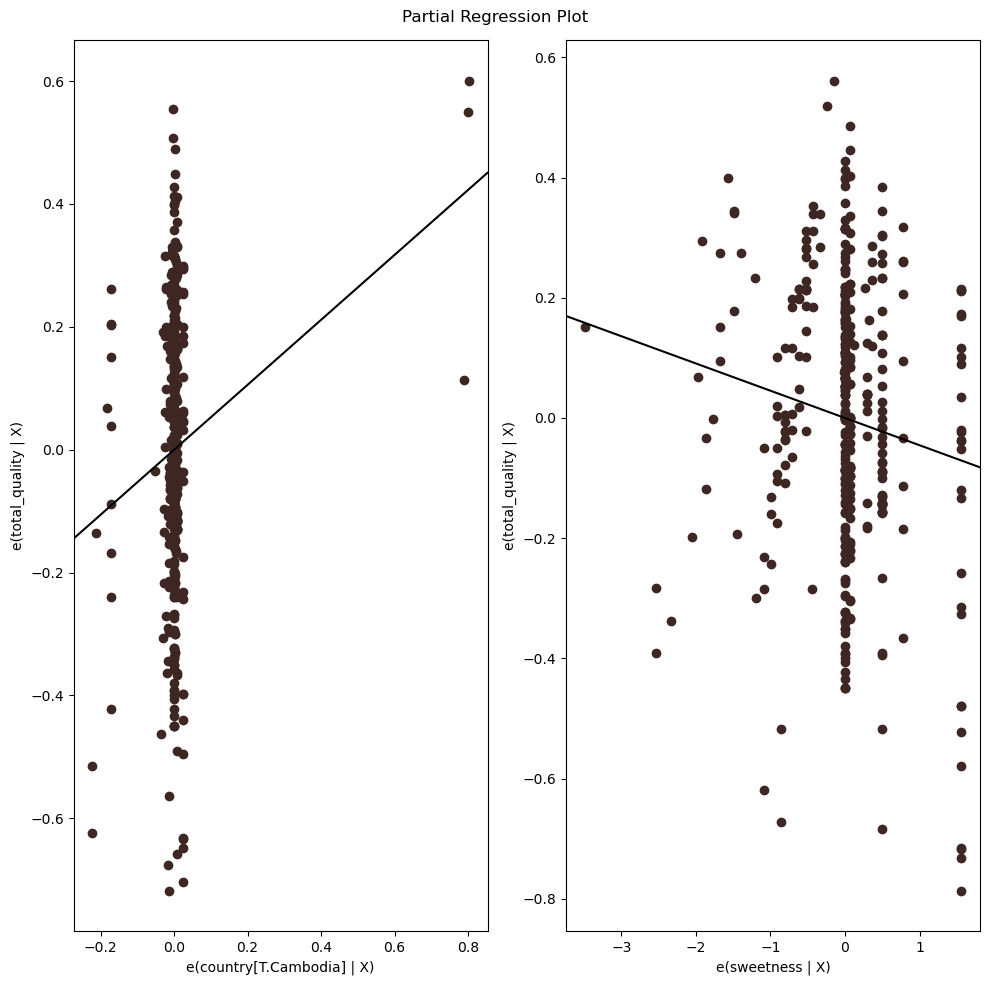

In [122]:
# Model with sweetness and country as predictors
model = smf.ols(formula='total_quality~sweetness+country',data=coffee).fit()
print(model.summary())

plt.figure(figsize=(15,6))

palette = ["#6F4E37", "#C04040"]

sns.pointplot(
    x='country',
    y='total_quality',
    hue='species',
    data=coffee,
    palette=palette,
    dodge=True,
    markers=['o','s'],
    linestyles=['-', '--']
)

plt.xticks(rotation=45)
plt.title("Interaction Between Country and Species Predicting Total Quality")
plt.ylabel("Mean Total Quality")
plt.xlabel("Country")
plt.show()

# One Hot Encoder
cats=["country"]
nums=["sweetness"]

preprocess=ColumnTransformer(transformers=[("encoder", OneHotEncoder(drop="first", handle_unknown='ignore'),cats),
                                           ("numeric","passthrough",nums)])

# Train-test split
X=coffee[['sweetness','country']]
y=coffee['total_quality']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=123)
ols=Pipeline(steps=[("preprocess", preprocess), ("model", LinearRegression())])
ols.fit(X_train, y_train)

# Train-test split
X=coffee[['sweetness','country']]
y=coffee['total_quality']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=123)
ols=Pipeline(steps=[("preprocess", preprocess), ("model", LinearRegression())])
ols.fit(X_train, y_train)

model1=ols.named_steps["model"]
predictors=ols.named_steps["preprocess"].get_feature_names_out()

charges_pred=ols.predict(X_test)
mse=mean_squared_error(y_test, charges_pred)
rmse=mse**0.5
print(rmse)

dat=pd.DataFrame({"Actual": y_test, "Predicted": charges_pred})

fig = px.scatter(dat,x="Actual",y="Predicted", trendline="ols")
fig.show()

# Residual vs. fitted plot
coffee['residual']=model.resid
coffee['fitted']=model.fittedvalues

fig=px.scatter(coffee, x="fitted", y="residual")
fig.add_hline(y=0, line_dash="dash", line_color="red")
fig.show()

# Partial regression plots
include=["country[T.Cambodia]","sweetness"]
graph=plt.figure(figsize=(10,10))
plot_partregress_grid(model, fig=graph,exog_idx=include)
plt.show()

In [123]:
country_counts = coffee['country'].value_counts()
country_counts

country
Taiwan              106
Vietnam              88
Thailand             61
Indonesia            31
Colombia             24
Ethiopia             16
Kenya                13
Brazil               13
Guatemala            11
India                 8
Japan                 3
Panama                3
Nicaragua             3
Cambodia              3
Costa Rica            2
Papua New Guinea      2
Uganda                2
El Salvador           2
Mexico                2
Honduras              1
Sri Lanka             1
Jamaica               1
Cameroon              1
Tanzania              1
Name: count, dtype: int64